In [2]:
import astropy.io.fits as fits
import numpy as np
import pandas
from astropy.table import unique,Table,setdiff,hstack,join
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
import warnings
from astropy.wcs import WCS
from astropy import units as u
from astropy.coordinates import SkyCoord, angular_separation
from astropy.cosmology import WMAP9 as cosmo

sami = Table.read('/suphys/fscu5535/python_scripts/raw_data/jvds_stelkin_cat_v012_mge_seecorr_kh20_v20220604_private.fits')
G09 = Table.read('/suphys/fscu5535/HSC_work/raw_data/G09+1degzlt0.3.fits',memmap=True)
sami.info()
G09.info()

<Table length=3430>
      name       dtype     class     n_bad
--------------- ------- ------------ -----
          CATID   int64       Column     0
      CATID_EXT   int64       Column     0
  SAMI_FILENAME bytes69       Column     0
       OBS_DATE bytes21       Column     0
             RA float32       Column     0
            DEC float32       Column     0
         LMSTAR float32       Column     0
         Z_SPEC float32       Column     0
        Z_TONRY float32 MaskedColumn   984
        GMINUSI float32       Column     0
       MU_AT_RE float32 MaskedColumn   984
       GAL_FLAG float32       Column     0
       HWHM_PSF float32       Column     0
             RE float32 MaskedColumn    53
    RE_CIRC_KPC float32 MaskedColumn    53
          ELLIP float32 MaskedColumn    52
       N_SERSIC float32 MaskedColumn   108
          MTYPE float32       Column     0
      KIN_MTYPE float32       Column     0
ENV_DIST_TO_5NN float32 MaskedColumn   130
   ENV_SURFDENS float32 MaskedColu

In [23]:
# classify objects as either star (3+ 0's), galaxy (3+ 1's) or unknown (rest)

object_id = []
object_type = []

for j in range(len(G09)):
    
    star_count = 0
    gal_count = 0
    
    object_id.append(G09['object_id'][j])
    
    for filt in ['r_extendedness_value','i_extendedness_value','z_extendedness_value',
                 'y_extendedness_value','g_extendedness_value']:
        if G09[filt][j] == 1:
            gal_count += 1
        if G09[filt][j] == 0:
            star_count += 1
    
    if star_count >= 3:
        object_type.append('s')
    elif gal_count >= 3:
        object_type.append('g')
    else:
        object_type.append('u')
        
# convert to table format and then left join to G09 table
data_to_add = Table()
data_to_add['object_id'] = object_id
data_to_add['object_type'] = object_type

G09 = join(G09,data_to_add,keys='object_id',join_type='left')

In [25]:
# save
G09.write('/suphys/fscu5535/HSC_work/mod_data/G09_1.0.fits')

In [44]:
# now extract all SAMI galaxies in G09 field

sami = Table.read('/suphys/fscu5535/python_scripts/raw_data/jvds_stelkin_cat_v012_mge_seecorr_kh20_v20220604_private.fits')

CATID = []
repeats = []
RA = []
DEC = []
Z = []
RE = []
ELLIP = []
LAMBDAR_RE = []


G09_min_RA = 128
G09_max_RA = 142

for i in range(len(sami)):
    if G09_min_RA <= sami['RA'][i] <= G09_max_RA:
 

        # don't store repeated CATID's twice
        if sami['CATID'][i] in CATID:
            repeats.append(sami['CATID'][i])
        else:            
            CATID.append(sami['CATID'][i])
            RA.append(sami['RA'][i])
            DEC.append(sami['DEC'][i])
            Z.append(sami['Z_SPEC'][i])
            RE.append(sami['RE_CIRC_KPC'][i])
            ELLIP.append(sami['ELLIP'][i])
            LAMBDAR_RE.append(sami['LAMBDAR_RE'][i])
            

print("total:",len(CATID))
print("unique:",len(set(CATID)))
print()

# check that repeated CATID's have the same values for each entry
# print("repeated ids")
# for j in repeats:
#     for k in range(len(sami)):
#         if j == sami['CATID'][k]:
#             print(sami['RA'][k])
#             print(sami['DEC'][k])
#             print(sami['Z_SPEC'][k])
#             print(sami['RE_CIRC_KPC'][k])
#             print()
#     print()
#     print()
    
# now store the results and save
G09_sami = Table()
G09_sami['CATID'] = CATID
G09_sami['RA'] = RA
G09_sami['DEC'] = DEC
G09_sami['Z_SPEC'] = Z
G09_sami['RE_CIRC_KPC'] = RE
G09_sami['ELLIP'] = ELLIP
G09_sami['LAMBDAR_RE'] = LAMBDAR_RE

G09_sami.write('/suphys/fscu5535/HSC_work/mod_data/G09_sami_1.0.fits')

total: 676
unique: 676



In [ ]:
c = SkyCoord(ra=jesse['RA'][5]*u.degree,dec=jesse['DEC'][5]*u.degree, distance=cosmo.comoving_distance(z=jesse['Z_SPEC'][5]))

In [51]:
# now try the galaxy pair calculation
# I can always left join additional HSC object info at a later time..

G09_hsc = Table.read('/suphys/fscu5535/HSC_work/mod_data/G09_1.0.fits',memmap=True)
G09_sami = Table.read('/suphys/fscu5535/HSC_work/mod_data/G09_sami_1.0.fits',memmap=True)

CATID = []
RA = []
DEC = []
Z_SPEC = []
RE_CIRC_KPC = []
object_id = []
distance = []

# try for 5 G09_sami gals first
for i in range(5):
    
    # store sami gal details
    CATID.append(G09_sami['CATID'][i])
    RA.append(G09_sami['RA'][i])
    DEC.append(G09_sami['DEC'][i])
    Z_SPEC.append(G09_sami['Z_SPEC'][i])
    RE_CIRC_KPC.append(G09_sami['RE_CIRC_KPC'][i])

    # create a list for the HSC objects
    object_id.append([])
    distance.append([])

    # sami gal skycoord object
    G09_sami_skycoord = SkyCoord(ra=G09_sami['RA'][i]*u.degree, dec=G09_sami['DEC'][i]*u.degree,
                                 distance=cosmo.comoving_distance(z=G09_sami['Z_SPEC'][i]))
    
    for j in range(len(G09_hsc)):
        
        # make sure object isn't a star
        if G09_hsc['object_type'][j] != 's':
        
            # HSC object skycoord object
            G09_hsc_skycoord = SkyCoord(ra=G09_hsc['ra'][j]*u.degree, dec=G09_hsc['dec'][j]*u.degree,
                                         distance=cosmo.comoving_distance(z=G09_hsc['photoz_median'][j]))
            
            # calculate distance
            sep = G09_sami_skycoord.separation_3d(G09_hsc_skycoord)
            
            # store results
            object_id[i].append(G09_hsc['object_id'][j])
            distance[i].append(sep)
            
    print(i)


0
1
2
3
4


In [64]:
print(CATID[0])

197419


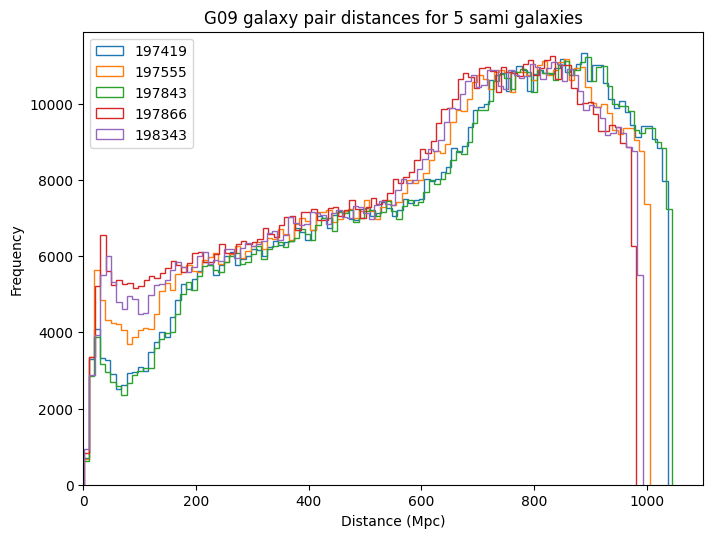

In [73]:
plt.figure(figsize=(8,6),dpi=100)
for i in range(len(distance)):
    plt.hist(distance[i],bins='auto',histtype='step', fill=False, label=CATID[i])
    
plt.xlim(0,1100)
plt.xlabel("Distance (Mpc)")
plt.ylabel("Frequency")
plt.title("G09 galaxy pair distances for 5 sami galaxies")
plt.legend(loc='upper left')

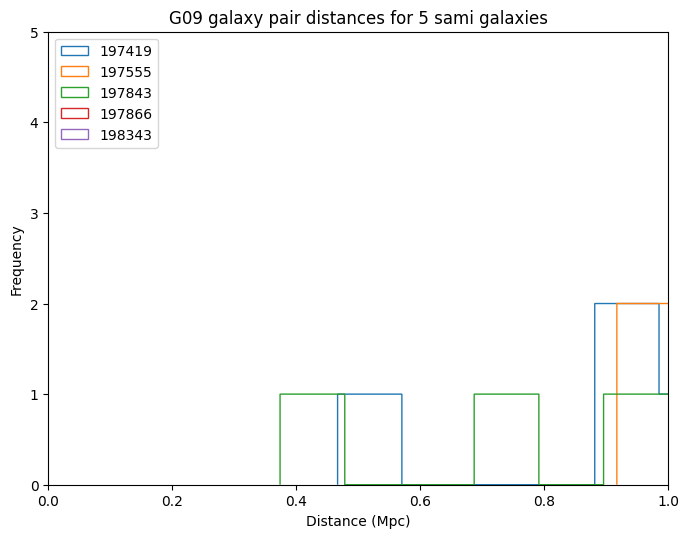

In [76]:
plt.figure(figsize=(8,6),dpi=100)
for i in range(len(distance)):
    plt.hist(distance[i],bins=10000,histtype='step', fill=False, label=CATID[i])
    
plt.xlim(0,5)
plt.ylim(0,5)
plt.xlabel("Distance (Mpc)")
plt.ylabel("Frequency")
plt.title("G09 galaxy pair distances for 5 sami galaxies")
plt.legend(loc='upper left')

In [79]:
for i in CATID:
    for j in range(len(sami)):
        if i == sami['CATID'][j]:
            print("Central val:",sami['SAMI_CENTRAL'][j])
            print("Isolated val:",sami['SAMI_ISO'][j])
            print("Satellite val:",sami['SAMI_SAT'][j])

Central val: --
Isolated val: 1.0
Satellite val: --
Central val: 1.0
Isolated val: --
Satellite val: --
Central val: --
Isolated val: 1.0
Satellite val: --
Central val: 1.0
Isolated val: --
Satellite val: --
Central val: --
Isolated val: 1.0
Satellite val: --


In [102]:
from astropy.wcs import WCS
ax = plt.subplot(projection=wcs)
plt.scatter(RA,DEC,c=['blue','yellow','green','red','purple'])
lon = ax.coords['ra']
lat = ax.coords['dec']
lon.set_major_formatter('hh:mm:ss')
lat.set_major_formatter('hh:mm:ss')


NameError: name 'wcs' is not defined

In [84]:
coords = []
for i in range(len(CATID)):
    
    coords.append(SkyCoord(ra=RA[i]*u.degree, dec=DEC[i]*u.degree,
                             distance=cosmo.comoving_distance(z=Z_SPEC[i])))
    


In [85]:
print(coords)

[<SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, Mpc)
    (135.20729065, -0.71429199, 174.16623979)>, <SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, Mpc)
    (135.80276489, -0.75292999, 206.86296129)>, <SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, Mpc)
    (137.34976196, -0.63915497, 168.51444831)>, <SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, Mpc)
    (137.44616699, -0.65182197, 232.52460225)>, <SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, Mpc)
    (139.04118347, -0.688824, 222.64035408)>]


In [90]:
coords[0].dec.hms

hms_tuple(h=-0.0, m=-2.0, s=-51.43007755279544)

In [92]:
newra = []
newdec = []

for i in coords:
    newra.append(i.ra.hms)
    newdec.append(i.dec.hms)

In [103]:
print(RA[0])

135.20729


In [107]:
24*RA[0]/360

9.013819376627604

In [112]:
# optimize data: remove stars from table, create new column for skycoord

good_hscIDs = []
hsc_coords = []

CATIDs = []
sami_coords = []

for i in range(len(G09_hsc)):
    if G09_hsc['object_type'][i] != 's':
        good_hscIDs.append(G09_hsc['object_id'][i])
        coordinates_hsc = SkyCoord(ra=G09_hsc['ra'][i]*u.degree, dec=G09_hsc['dec'][i]*u.degree,
                               distance=cosmo.comoving_distance(z=G09_hsc['photoz_median'][i]))
        hsc_coords.append(coordinates_hsc)
        
for j in range(len(G09_sami)):
    CATIDs.append(G09_sami['CATID'][j])
    coordinates_sami = SkyCoord(ra=G09_sami['RA'][j]*u.degree, dec=G09_sami['DEC'][j]*u.degree,
                           distance=cosmo.comoving_distance(z=G09_sami['Z_SPEC'][j]))
    sami_coords.append(coordinates_sami)
    
hsc_to_add = Table()
hsc_to_add['object_id'] = good_hscIDs
hsc_to_add['SkyCoord'] = hsc_coords       
G09_hsc = join(hsc_to_add, G09_hsc, keys='object_id', join_type='left')

G09_hsc.write('/suphys/fscu5535/HSC_work/mod_data/G09_hsc_1.1.fits')

sami_to_add = Table()
sami_to_add['CATID'] = CATIDs
sami_to_add['SkyCoord'] = sami_coords
G09_sami = join(sami_to_add, G09_sami, keys='CATID', join_type='left')

G09_sami.write('/suphys/fscu5535/HSC_work/mod_data/G09_sami_1.1.fits')





In [133]:
#keep only 'g' hsc objects

good_hscIDs = []
hsc_coords = []


for i in range(len(G09_hsc)):
    if G09_hsc['object_type'][i] == 'g':
        good_hscIDs.append(G09_hsc['object_id'][i])
        coordinates_hsc = SkyCoord(ra=G09_hsc['ra'][i]*u.degree, dec=G09_hsc['dec'][i]*u.degree,
                               distance=cosmo.comoving_distance(z=G09_hsc['photoz_median'][i]))
        hsc_coords.append(coordinates_hsc)
        
hsc_to_add = Table()
hsc_to_add['object_id'] = good_hscIDs
hsc_to_add['SkyCoord'] = hsc_coords       
G09_hsc = join(hsc_to_add, G09_hsc, keys='object_id', join_type='left')

G09_hsc.write('/suphys/fscu5535/HSC_work/mod_data/G09_hsc_1.1b(gonly).fits')

In [3]:
G09_hsc = Table.read('/suphys/fscu5535/HSC_work/mod_data/G09_hsc_1.1b(gonly).fits')
G09_hsc.info()

<Table length=503743>
            name             dtype      unit       class     n_bad
--------------------------- ------- ----------- ------------ -----
                  object_id   int64             MaskedColumn     0
                 SkyCoord_1  object deg,deg,Mpc     SkyCoord     0
                 SkyCoord_2  object deg,deg,Mpc     SkyCoord     0
           object_id_isnull    bool                   Column     0
                         ra float64                   Column     0
                  ra_isnull    bool                   Column     0
                        dec float64                   Column     0
                 dec_isnull    bool                   Column     0
              photoz_median float32                   Column     0
       photoz_median_isnull    bool                   Column     0
              i_psfflux_mag float32             MaskedColumn   612
       i_psfflux_mag_isnull    bool                   Column     0
              r_psfflux_mag float32     

In [5]:
# now try the galaxy pair calculation AGAIN, for ONLY definite galaxies
# I can always left join additional HSC object info at a later time..

G09_hsc = Table.read('/suphys/fscu5535/HSC_work/mod_data/G09_hsc_1.1b(gonly).fits',memmap=True)
G09_sami = Table.read('/suphys/fscu5535/HSC_work/mod_data/G09_sami_1.1.fits',memmap=True)

CATID = []
object_id = []
distance = []

# try for ?? G09_sami gals first
for i in range(len(G09_sami)):
    
    # store sami gal details
    CATID.append(G09_sami['CATID'][i])

    # create a list for the HSC objects
    object_id.append([])
    distance.append([])
    
    for j in range(len(G09_hsc)):
                  
        # calculate distance, store results if within 1.5 mpc
        if G09_sami['SkyCoord'][i].separation_3d(G09_hsc['SkyCoord_1'][j]) < 1.5*u.Mpc:
            object_id[i].append(G09_hsc['object_id'][j])
            distance[i].append(sep)
            
    print(i,"/",len(G09_sami),"done")
    
    # 17-2-23 5:15pm start

NameError: name 'sep' is not defined

In [120]:
first40samigals = distance
first40samigals.write('~')

Text(0.5, 1.0, 'G09 galaxy pair distances for 40 sami galaxies')

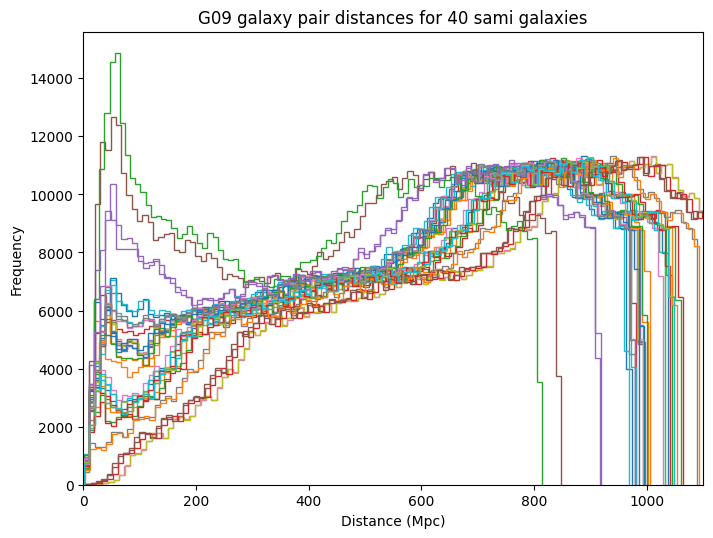

In [121]:
plt.figure(figsize=(8,6),dpi=100)
for i in range(len(first40samigals)):
    plt.hist(first40samigals[i],bins='auto',histtype='step', fill=False)
    
plt.xlim(0,1100)
plt.xlabel("Distance (Mpc)")
plt.ylabel("Frequency")
plt.title("G09 galaxy pair distances for 40 sami galaxies")

Text(0.5, 1.0, 'G09 galaxy pair distances for 40 sami galaxies')

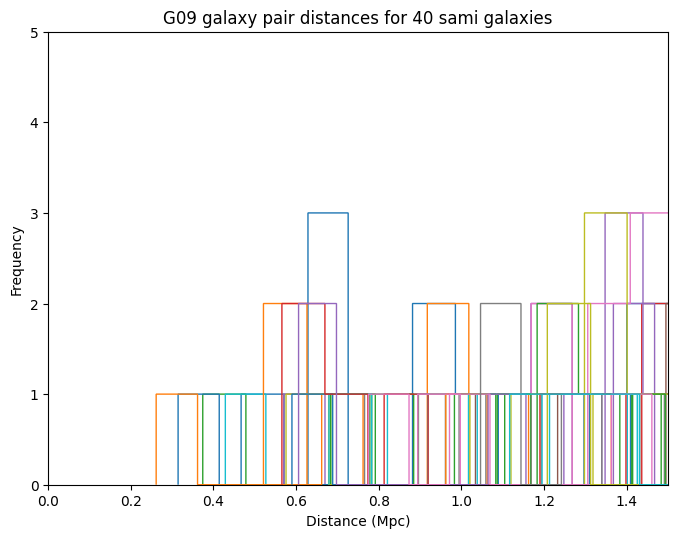

In [123]:
plt.figure(figsize=(8,6),dpi=100)
for i in range(len(first40samigals)):
    plt.hist(first40samigals[i],bins=10000,histtype='step', fill=False,)
    
plt.xlim(0,1.5)
plt.ylim(0,5)
plt.xlabel("Distance (Mpc)")
plt.ylabel("Frequency")
plt.title("G09 galaxy pair distances for 40 sami galaxies")

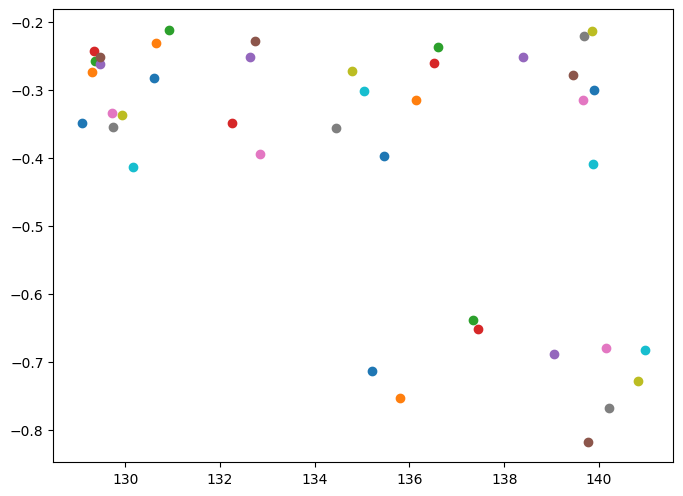

In [126]:
plt.figure(figsize=(8,6),dpi=100)
for i in range(len(CATID)):
    plt.scatter(RA[i],DEC[i])

In [131]:
distance[0][1] < 40*u.Mpc

True

In [130]:
print(distance[0][1])

39.2105457643167 Mpc


In [1]:
import multiprocessing

print("Number of cpu : ", multiprocessing.cpu_count())

Number of cpu :  20


In [2]:
from multiprocessing import Process


def print_func(continent='Asia'):
    print('The name of continent is : ', continent)

if __name__ == "__main__":  # confirms that the code is under main function
    names = ['America', 'Europe', 'Africa']
    procs = []
    proc = Process(target=print_func)  # instantiating without any argument
    procs.append(proc)
    proc.start()

    # instantiating process with arguments
    for name in names:
        # print(name)
        proc = Process(target=print_func, args=(name,))
        procs.append(proc)
        proc.start()

    # complete the processes
    for proc in procs:
        proc.join()

The name of continent is : The name of continent is :   AmericaAsia

The name of continent is :  Europe
The name of continent is :  Africa


In [45]:
# do projected separation instead. assume HSC object is at same redshift as SAMI galaxy
# test to see if separation_3d gives the same projected separation as angular_separation + angular_diameter_distance


# read in definite galaxies, just work with these for now..
HSC_G09_gals = Table.read('/suphys/fscu5535/HSC_work/mod_data/G09_HSC_galaxies.fits')

# sami gals
SAMI_G09_gals = Table.read('/suphys/fscu5535/HSC_work/mod_data/G09_sami_1.1.fits')

# test for small number?? of galaxies first

# sep_3d approach
co_dist = cosmo.comoving_distance(z=SAMI_G09_gals['Z_SPEC'][0])
print(SAMI_G09_gals['Z_SPEC'][0])
test_SAMI = SkyCoord(ra=SAMI_G09_gals['RA'][0]*u.deg,dec=SAMI_G09_gals['DEC'][0]*u.deg,distance=co_dist)
test_HSC_old = SkyCoord(ra=HSC_G09_gals['ra'][0]*u.deg,dec=HSC_G09_gals['dec'][0]*u.deg,
                        distance=cosmo.comoving_distance(z=HSC_G09_gals['photoz_median'][0]))
test_HSC_new = SkyCoord(ra=HSC_G09_gals['ra'][0]*u.deg,dec=HSC_G09_gals['dec'][0]*u.deg,
                        distance=co_dist)

sep1_old = test_SAMI.separation_3d(test_HSC_old)
sep1_new = test_SAMI.separation_3d(test_HSC_new)

print("separation_3d:",sep1_old)
print("projected sep using separation_3d, SAMI z for HSC object:",sep1_new)

# angular_sep + angular_diameter_distance approach
ang_sep = angular_separation(SAMI_G09_gals['RA'][0]*u.deg,SAMI_G09_gals['DEC'][0]*u.deg,
                            HSC_G09_gals['ra'][0]*u.deg,HSC_G09_gals['dec'][0]*u.deg)

print("angular sep:", ang_sep)

ang_diam_1rad = cosmo.angular_diameter_distance(SAMI_G09_gals['Z_SPEC'][0])*1/u.rad
print("ang_diameter_distance @ SAMI z:",ang_diam_1rad)

ang_diam = ang_diam_1rad*ang_sep
print("projected sep using ang_sep and ang_dist:",ang_diam)


0.04063
separation_3d: 890.8783227815287 Mpc
projected sep using separation_3d, SAMI z for HSC object: 20.698317453806908 Mpc
angular sep: 0.11891235290918069 rad
ang_diameter_distance @ SAMI z: 167.36615274377542 Mpc / rad
projected sep using ang_sep and ang_dist: 19.90190302011966 Mpc


In [62]:
# looks good?? now try on full sample
CATIDS = []
object_ids = []
distances = []

for i in range(len(SAMI_G09_gals)):
    ang_diam_1rad = cosmo.angular_diameter_distance(SAMI_G09_gals['Z_SPEC'][i])*1/u.rad
    CATIDS.append(SAMI_G09_gals['CATID'][i])
    object_ids.append([])
    distances.append([])
    
    for j in range(len(HSC_G09_gals)):       
        ang_sep = angular_separation(SAMI_G09_gals['RA'][i]*u.deg,SAMI_G09_gals['DEC'][i]*u.deg,
                            HSC_G09_gals['ra'][j]*u.deg,HSC_G09_gals['dec'][j]*u.deg)
        sep = ang_sep*ang_diam_1rad
    
        if sep < 1*u.Mpc:
            object_ids[i].append(HSC_G09_gals['object_id'][j])
            distances[i].append(sep)
    
    print(i,"/",len(SAMI_G09_gals),"done")

# 5:19pm 27/2/23 start

0 / 676 done
1 / 676 done
2 / 676 done
3 / 676 done
4 / 676 done
5 / 676 done
6 / 676 done


KeyboardInterrupt: 

Text(0.5, 1.0, 'G09 galaxy pair (projected) distances for 7 sami galaxies')

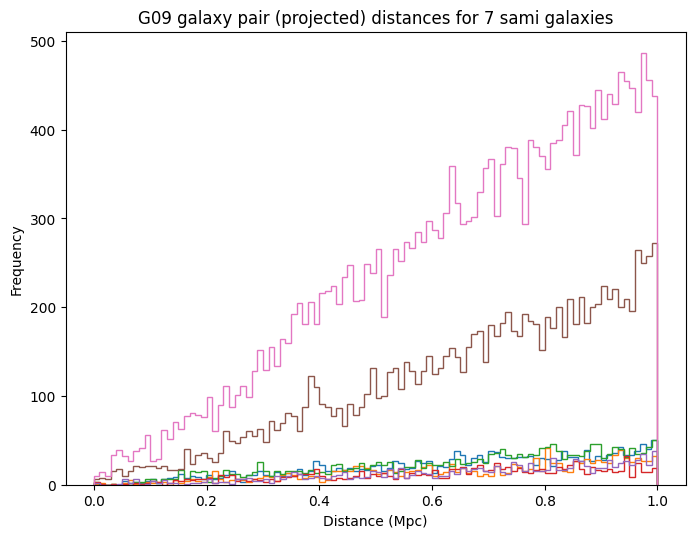

In [71]:
# plot prelim results
plt.figure(figsize=(8,6),dpi=100)
for i in range(7):
    plt.hist(distances[i],bins=100,histtype='step', fill=False)
    

plt.xlabel("Distance (Mpc)")
plt.ylabel("Frequency")
plt.title("G09 galaxy pair (projected) distances for 7 sami galaxies")

In [3]:
# inspect random data
randoms = Table.read('/suphys/fscu5535/HSC_work/mod_data/G09+1deg_randoms.fits')
randoms.info()

<Table length=46561760>
      name        dtype 
---------------- -------
       object_id   int64
object_id_isnull    bool
              ra float64
       ra_isnull    bool
             dec float64
      dec_isnull    bool
